In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/')
import rotarod_analysis as ra
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import itertools
from multiprocessing import Pool
import functools
from scipy import sparse 

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

In [3]:
reload(ra)
reload(utils_jjm)

<module 'python_utils_jjm' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/python_utils_jjm.py'>

In [16]:
#base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/rotarod/'
base_dir = '/volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'

In [17]:
CNMFE_files = {'3_11_2020': base_dir + '08-Apr_16_03_01_out.mat',
              '3_13_2020': base_dir + '08-Apr_22_54_12_out.mat',}
              #'3_17_2020': base_dir + '12-Apr_21_20_00_out.mat',
              #'3_19_2020': base_dir + '12-Apr_19_48_06_out.mat',}

In [18]:
# load fluorescence data from CNMFE files

In [19]:
CNMFE_data = {day:ra.get_CNMFE_fluorescence(CNMFE_file) for day, CNMFE_file in CNMFE_files.items()}

In [20]:
#filter Z score and center of mass data
filtered_CNMFE_data = {day:{'C_normalized_z_scored' : utils_jjm.filter_out_by_size(CNMFE_data[day]['C_normalized_z_scored'], 
                                                                              CNMFE_data[day]['cell_contours'], 
                                                                              CNMFE_data[day]['for_dims'], 0.6, 100).drop(['msCamFrame'], axis=1), 
                            'com_filtered' : utils_jjm.filter_out_by_size(CNMFE_data[day]['com'].transpose(), 
                                                                        CNMFE_data[day]['cell_contours'], 
                                                                        CNMFE_data[day]['for_dims'], 0.6, 100)}
                       for day in list(CNMFE_files.keys())}

In [21]:
## align frames by session 
CNMFE_frames = {day:ra.align_frames(CNMFE_file) for day, CNMFE_file in CNMFE_files.items()}

In [22]:
CNMFE_frames['3_11_2020']

,final_frame,cumulative_frames,frame_indicies
H19_M46_S0,1977,1977,"(0, 1977)"
H19_M51_S4,2561,4538,"(1977, 4538)"
H19_M55_S57,3388,7926,"(4538, 7926)"
H20_M0_S57,4712,12638,"(7926, 12638)"
H20_M11_S42,5216,17854,"(12638, 17854)"
H20_M17_S28,4574,22428,"(17854, 22428)"
H20_M22_S56,4993,27421,"(22428, 27421)"
H20_M28_S4,4370,31791,"(27421, 31791)"
H20_M33_S18,5993,37784,"(31791, 37784)"
H20_M6_S41,4465,42249,"(37784, 42249)"


# do some analysis of the trials within each days session  

In [10]:
list(CNMFE_data.keys())

['3_11_2020', '3_13_2020', '3_17_2020', '3_19_2020']

In [11]:
results_by_day = {}
#for day in list(CNMFE_data.keys()):
for day in list(CNMFE_data.keys()):
    event_counts, trial_stats = ra.trial_stats(CNMFE_frames[day], filtered_CNMFE_data[day]['C_normalized_z_scored'], 2)
    results_by_day[day] = {'event_counts': event_counts,
                           'trial_stats': trial_stats}

In [12]:
#average firing rates per day 
avg_firing_rate_day = [np.mean([np.mean(results_by_day[day]['trial_stats'][session]['event_rates_by_cell']) for session in np.array(CNMFE_frames[day].index)]) for day in list(CNMFE_data.keys())]
avg_firing_rate_sessions_by_day = {day:rate for day, rate in zip(list(CNMFE_data.keys()),
                                                                 [[np.mean(results_by_day[day]['trial_stats'][session]['event_rates_by_cell']) for session in np.array(CNMFE_frames[day].index)] for day in list(CNMFE_data.keys())])}

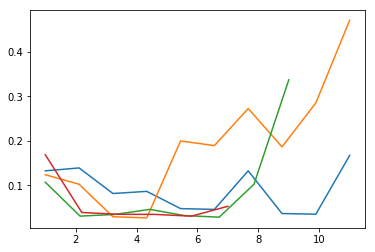

In [13]:
for day in list(avg_firing_rate_sessions_by_day.keys()):
    plt.plot(np.linspace(1, len(avg_firing_rate_sessions_by_day[day])+1, len(avg_firing_rate_sessions_by_day[day])),
             avg_firing_rate_sessions_by_day[day])
plt.show()           

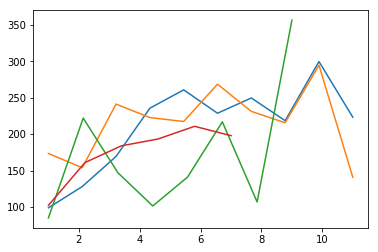

In [15]:
for day in list(avg_firing_rate_sessions_by_day.keys()):
    plt.plot(np.linspace(1, len(CNMFE_frames[day]['final_frame'].values)+1, len(CNMFE_frames[day]['final_frame'].values)),
        CNMFE_frames[day]['final_frame'].values.astype(np.float)*.05)

In [16]:
# measure spatial coordination 
filtered_CNMFE_data[day]['com_filtered']

,1,2,3,4,5,6,7,8,9,10,...,112,114,115,116,117,118,119,120,121,123
y,380.509893,240.850321,220.735290,354.773638,281.032443,363.251339,358.602142,260.915968,305.477730,403.934220,...,420.281143,209.774917,339.222673,163.363749,204.896148,461.098619,300.609863,357.216040,333.768866,255.536296
x,109.388111,171.089295,167.159247,178.217938,235.292795,220.769060,202.994200,130.040169,130.329212,146.477572,...,331.295301,371.393662,403.912060,198.342236,264.513018,378.082710,221.977560,231.350029,173.773089,301.302868


In [17]:
filtered_CNMFE_data[day]['C_normalized_z_scored'].head()

,1,2,3,4,5,6,7,8,9,10,...,112,114,115,116,117,118,119,120,121,123
00:00:00,-0.444055,-0.348601,0.151198,0.571605,-0.170278,0.119106,-0.344656,-0.402019,1.876756,0.497051,...,-0.018978,-0.312597,-0.220074,-0.291306,0.508004,-0.174240,0.155821,0.753629,2.141595,1.217110
00:00:00.050000,-0.444055,-0.348601,0.079845,1.355781,-0.177401,0.769792,-0.338934,-0.402019,1.482140,0.445421,...,-0.077652,-0.340053,-0.247248,-0.323145,0.351011,-0.218523,1.395959,0.598288,4.387438,1.307685
00:00:00.100000,-0.444055,-0.126014,0.017158,1.514577,-0.184167,1.070214,0.226904,-0.402019,2.816659,0.397374,...,-0.129452,-0.375078,0.131985,0.720290,0.533823,0.070174,3.872180,0.461322,5.988862,1.142920
00:00:00.150000,-0.444055,-0.133283,-0.037913,2.123120,-0.190592,0.976132,0.125682,-0.402019,4.043884,0.352663,...,-0.175182,-0.178561,0.066496,0.605920,0.373424,-0.037329,3.297194,0.340559,5.083807,1.994871
00:00:00.200000,-0.444055,-0.140314,-0.086295,1.962718,-0.196695,0.888114,0.038334,-0.321909,6.026727,0.311054,...,-0.215555,0.561769,0.008134,2.005508,0.363969,1.344551,2.794651,1.338193,4.298487,1.773426


In [18]:
def map_to_sparse_matrix(cell_pairs, orig_df_comparison, time_index):
    indicies_to_update = []
    if time_index%100==0:
        print(time_index)
    for pair, pair_idx in zip(cell_pairs, range(len(cell_pairs))):
        if (orig_df_comparison.loc[time_index][pair[0]] == 1) and (orig_df_comparison.loc[time_index][pair[1]] == 1):
            indicies_to_update.append((time_index, pair_idx))
        else:
            pass
    return(indicies_to_update)

In [19]:
list(CNMFE_data.keys())

['3_11_2020', '3_13_2020', '3_17_2020', '3_19_2020']

In [27]:
days = ['3_13_2020']

In [ ]:
coactivity_by_day = {}
for day in days:
    
    binned_fluorescence = filtered_CNMFE_data[day]['C_normalized_z_scored'].apply(utils_jjm.binning_function_uncrop, args=[1, 4])
    reindexed = binned_fluorescence.set_index(int(x) for x in np.linspace(0, len(binned_fluorescence)-1, len(binned_fluorescence)))
    cell_pairs = np.array([pair for pair in itertools.combinations(list(reindexed.columns), 2)])
    #create dictionary of cell pairs, keys are index in the list of pair combinations
    pairs_dict = {pair_idx:pair for (pair_idx , pair) in zip(range(len(cell_pairs)), cell_pairs)}
    coactivity_in_session_p = sparse.dok_matrix((len(reindexed), len(cell_pairs)))

    # search for indicies with coactivity
    print(day)
    p=Pool(12)

    indicies = [cell_indicies for cell_indicies in list(p.map(functools.partial(map_to_sparse_matrix, cell_pairs, reindexed), range(len(reindexed)))) if len(cell_indicies)>0]
    indicies_flattened = [indx for sublist in indicies for indx in sublist]

    p.close

    # update the coactivity matrix 
    for dok_index in indicies_flattened:
        coactivity_in_session_p[dok_index[0], dok_index[1]] = 1
    
    coactivity_by_day[day] = {'coactivity_in_session': coactivity_in_session_p, 'cell_pairs':pairs_dict}

3_13_2020
0
900
1800
2700
3600
4500
5400
6300
7200
8100
9000
9900
9100
10000
7300
5500
100
6400
8200
2800
3700
1000
1900
4600
10100
7400
9200
5600
6500
8300
200
1100
4700
3800
2000
2900
9300
10200
8400
5700
6600
7500
300
1200
3900
4800
3000
2100
9400
10300
8500
5800
7600
6700
1300
4000
400
3100
4900
2200
9500
8600
10400
7700
4100
500
3200
5900
1400
6800
5000
2300
9600
8700
10500
7800
4200
3300
600
1500
6000
5100
6900
2400
8800
9700
10600
7900
4300
3400
700
1600
6100
5200
7000
2500
8900
9800
10700
8000
3500
800
4400
1700
6200
7100
5300
2600
10800
11700
12600
13500
14400
15300
16200
17100
18000
18900
19800
20700
10900
11800
12700
13600
14500
15400
16300
17200
18100
19900
19000
20800
11000
11900
12800
13700
15500
14600
16400
17300
18200
20000
19100
20900
11100
12000
12900
13800
15600
14700
16500
17400
18300
20100
19200
21000
11200
12100
13000
13900
15700
14800
16600
17500
20200
18400
19300
21100
11300
12200
13100
14000
14900
15800
16700
17600
20300
18500
19400
21200
11400
12300
13200
1410

In [26]:
directory_path='/projects/p30771/miniscope/analysis/rotarod_analysis/spatial_clustering/zscore_4/'
for day in days:
    csr_matrix = coactivity_by_day[day]['coactivity_in_session'].tocsc()

    sparse.save_npz(directory_path+str(day)+".npz",
                      csr_matrix)

    pd.DataFrame(coactivity_by_day[day]['cell_pairs']).to_csv(directory_path+str(day)+".csv")

# load up output of dlc files 

In [16]:
# index intervals open left
CNMFE_frames['3_11_2020']

,final_frame,cumulative_frames,frame_indicies
H19_M46_S0,1977,1977,"(0, 1977)"
H19_M51_S4,2561,4538,"(1977, 4538)"
H19_M55_S57,3388,7926,"(4538, 7926)"
H20_M0_S57,4712,12638,"(7926, 12638)"
H20_M11_S42,5216,17854,"(12638, 17854)"
H20_M17_S28,4574,22428,"(17854, 22428)"
H20_M22_S56,4993,27421,"(22428, 27421)"
H20_M28_S4,4370,31791,"(27421, 31791)"
H20_M33_S18,5993,37784,"(31791, 37784)"
H20_M6_S41,4465,42249,"(37784, 42249)"


In [17]:
session = 'H19_M46_S0'

In [64]:
dlc_df = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/rotarod/3_11_2020/'+session+'/'+session+'_dlc_coordinates_tracking_foranalysis_05122020.csv', 
                     header=[0, 1, 2]).drop(['level_0', 'index'], axis=1)

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [65]:
dlc_df

scorer DLC_resnet50_GRIN_rotarod_rearviewApr2shuffle1_300000  \
            bodyparts                                             tail_base   
               coords                                                     x   
0            00:00:00                                         277.722870      
1     00:00:00.050025                                         277.722870      
2     00:00:00.100050                                         277.876740      
3     00:00:00.150075                                         277.591949      
4     00:00:00.200101                                         277.716156      
...               ...                                                ...      
1972  00:01:38.649898                                         335.015472      
1973  00:01:38.699924                                         335.192871      
1974  00:01:38.749949                                         341.827332      
1975  00:01:38.799974                                         335.209381      
1976  00:01:38.850000                                         335.035919      

                                                                            \
                             left_r_paw                        right_r_paw   
               y likelihood           x           y likelihood           x   
0     316.552338   0.999997   93.878006  400.479645   0.002830  322.205505   
1     316.552338   0.999997   93.878006  400.479645   0.002830  322.205505   
2     316.716766   0.999996   93.779655  400.543304   0.002138  322.074158   
3     316.828613   0.999996   93.470978  400.894897   0.002452  323.323822   
4     316.846832   0.999996   93.750488  400.907043   0.002153  322.126038   
...          ...        ...         ...         ...        ...         ...   
1972  408.643768   0.001500  331.070160  414.997162   0.001979  210.885086   
1973  408.625702   0.001830  331.085724  414.812042   0.002107  226.447388   
1974  396.818329   0.001123  330.953857  414.745178   0.001593  461.516846   
1975  408.300507   0.001375  330.863098  414.696930   0.001771  335.402710   
1976  408.471008   0.001578  331.096130  414.840271   0.002088  461.794189   

                             ...                                     \
                             ...  left_f_paw                          
               y likelihood  ...           x           y likelihood   
0     272.862671   1.000000  ...   89.059441  396.405060   0.002076   
1     272.862671   1.000000  ...   89.059441  396.405060   0.002076   
2     272.814209   1.000000  ...   89.000626  396.439117   0.001702   
3     271.056519   1.000000  ...   89.071907  396.291656   0.001836   
4     272.929993   1.000000  ...   88.835999  396.383820   0.001605   
...          ...        ...  ...         ...         ...        ...   
1972  301.231567   0.009314  ...  331.536835  412.838226   0.001678   
1973  301.314972   0.005944  ...  331.626923  412.994385   0.001739   
1974  190.215302   0.007593  ...  331.486115  412.796539   0.001381   
1975  408.142212   0.003843  ...  331.545532  412.623108   0.001485   
1976  189.425171   0.006372  ...  331.567352  412.739197   0.001691   

                                                                            \
     right_f_paw                           centroid                          
               x           y likelihood           x           y likelihood   
0      91.855232  395.525391   0.002050  185.895387  383.521210   0.333397   
1      91.855232  395.525391   0.002050  185.895387  383.521210   0.333397   
2      91.568123  395.606049   0.001651  184.940965  373.210156   0.334698   
3      91.546577  395.390533   0.001924  158.111836  376.309995   0.322679   
4      91.915596  395.473236   0.001600  158.122697  376.526227   0.340071   
...          ...         ...        ...         ...         ...        ...   
1972  331.057220  411.874268   0.002106  319.185463  398.914554   0.201806   
1973  331.113953  411.946106   0.002170 